## Modellierung (1)

### Modell stadt-land-intermediär & sozioökonomische-Faktoren

Multiple lineare Regression nach Raumstruktur (stadt-land-intermediär & sozioökonomische-Faktoren)
1) ohne sozioökonomische Faktoren
2) dann Erweiterung

unabhängige Variable (X-Parameter) :
- Numerisch: Alter
- Kategorisch: Haushaltseinkommen, Geschlecht, Raum

abhängige Variable (Y-Parameter) : 
- CO₂-Emissionen

Szenario-Analyse: 
Analog zu Literatur-Erkenntnissen (e.g., Bevölkerungszuwachs in Städten etc.)

## 0. Vorbereitung: Import der benötigten Python-Libraries 

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline     
sns.set(color_codes=True)
from sklearn.model_selection import train_test_split

In [2]:
# Spezifisch für die linearen Modelle:
import sklearn as sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
# Laden der Datei wege.gpkg
wege = gpd.read_file('wege.gpkg')

# Anzeigen der ersten Zeilen der Datei
wege.head()


,HHNR,HH_BFS_NR,HH_PLZ,HH_ORT,HH_KANTON,HH_OEV_GUETEKLASSE,HH_STADT_LAND,HH_HAUSHALTSGROESSE,HH_HAUSHALTSEINKOMMEN,ZP_ALTER,...,FAHRZEUG_ENERGIEEFFIZIENZKLASSE,FAHRZEUG_VERBRAUCH,EL_Verbrauch,FAHRZEUG_JAHR_ERSTE_INVERKEHRSSETZUNG,ABSCHNITTLÄNGE_IN_KM,HH_RAUMTYPOLOGIE_9,CO2E_KG_KM_AUTO,CO2E_KG_KM_OTHER,CO2E_TOTAL,geometry
0,110001,5624,1030,Bussigny,22,3,Städtisch (1),2,5,57,...,D,-99.0,-99.0,-97.0,0.414223,Städtische Gemeinde einer grossen Agglomeratio...,200.4,NaN,83.010354,"LINESTRING Z (2532653.357 1155702.624 420.558,..."
1,110001,5624,1030,Bussigny,22,3,Städtisch (1),2,5,57,...,D,-99.0,-99.0,-97.0,0.307909,Städtische Gemeinde einer grossen Agglomeratio...,200.4,NaN,61.705018,"LINESTRING Z (2532933.573 1155665.561 430.418,..."
2,110001,5624,1030,Bussigny,22,3,Städtisch (1),2,5,57,...,D,-99.0,-99.0,-97.0,0.586282,Städtische Gemeinde einer grossen Agglomeratio...,200.4,NaN,117.490869,"LINESTRING Z (2533071.108 1155894.339 430.657,..."
3,110001,5624,1030,Bussigny,22,3,Städtisch (1),2,5,57,...,D,-99.0,-99.0,-97.0,1.599024,Städtische Gemeinde einer grossen Agglomeratio...,200.4,NaN,320.444438,MULTILINESTRING Z ((2532653.357 1155702.624 41...
4,110001,5624,1030,Bussigny,22,3,Städtisch (1),2,5,57,...,D,-99.0,-99.0,-97.0,2.445678,Städtische Gemeinde einer grossen Agglomeratio...,200.4,NaN,490.113940,"LINESTRING Z (2532957.334 1156871.023 475.614,..."


In [4]:
print(wege.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 552622 entries, 0 to 552621
Data columns (total 41 columns):
 #   Column                                 Non-Null Count   Dtype   
---  ------                                 --------------   -----   
 0   HHNR                                   552622 non-null  int64   
 1   HH_BFS_NR                              552622 non-null  int64   
 2   HH_PLZ                                 552622 non-null  int64   
 3   HH_ORT                                 552622 non-null  object  
 4   HH_KANTON                              552622 non-null  int64   
 5   HH_OEV_GUETEKLASSE                     552622 non-null  int64   
 6   HH_STADT_LAND                          552622 non-null  object  
 7   HH_HAUSHALTSGROESSE                    552622 non-null  int64   
 8   HH_HAUSHALTSEINKOMMEN                  552622 non-null  int64   
 9   ZP_ALTER                               552622 non-null  int64   
 10  ZP_GESL                             

In [5]:
# Verschiedene Werte HH_STADT_LAND anzeigen
wege['HH_STADT_LAND'].unique()

array(['Städtisch (1)', 'Intermediär (2)', 'Ländlich (3)'], dtype=object)

## 2. Vorverarbeitung der Daten


Die Verarbeitung wurde bei der Bearbeitung des Originaldatensatzes bzw. bei der Ermittlung der CO₂-Werte grösstenteils bereits abgeschlossen. Es sind lediglich minimale Anpassungen erforderlich, um kategoriale Werte in numerische Dummy-Variablen umzuwandeln. Dies betrifft ausschliesslich den Parameter HH_STADT_LAND und HH_HAUSHALTSEINKOMMEN da die Dummy-Variablen für die übrigen Parameter bereits erstellt wurden.

In [6]:
### 2.1. Transformation von Werten

# Umwandlung von HH_STADT_LAND
wege['HH_STADT_LAND'] = wege['HH_STADT_LAND'].map({
    'Städtisch (1)': 1,
    'Intermediär (2)': 2,
    'Ländlich (3)': 3
})

# Umwandlung von HH_HAUSHALTSEINKOMMEN
wege['HH_HAUSHALTSEINKOMMEN'] = wege['HH_HAUSHALTSEINKOMMEN'].replace({
    -99: None, # Nicht gestellt
    -98: None, # Keine Antwort
    -97: None, # Weiss nicht
    1: 2000, # Unter CHF 2000
    2: 4000, # CHF 2000 bis 4000
    3: 6000, # CHF 4001 bis 6000
    4: 8000, # CHF 6001 bis 8000
    5: 10000, # CHF 8001 bis 10000
    6: 12000, # CHF 10001 bis 12000
    7: 14000, # CHF 12001 bis 14000
    8: 16000, # CHF 14001 bis 16000
    9: 18000  # Mehr als CHF 16000
})

# Anzeigen der ersten Zeilen zur Überprüfung
print(wege[['HH_STADT_LAND', 'ZP_GESL', 'HH_HAUSHALTSEINKOMMEN',]].head())


   HH_STADT_LAND  ZP_GESL  HH_HAUSHALTSEINKOMMEN
0              1        1                10000.0
1              1        1                10000.0
2              1        1                10000.0
3              1        1                10000.0
4              1        1                10000.0


C:\Users\User\AppData\Local\Temp\ipykernel_19872\1250325597.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wege['HH_HAUSHALTSEINKOMMEN'] = wege['HH_HAUSHALTSEINKOMMEN'].replace({


In [7]:
print(wege.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 552622 entries, 0 to 552621
Data columns (total 41 columns):
 #   Column                                 Non-Null Count   Dtype   
---  ------                                 --------------   -----   
 0   HHNR                                   552622 non-null  int64   
 1   HH_BFS_NR                              552622 non-null  int64   
 2   HH_PLZ                                 552622 non-null  int64   
 3   HH_ORT                                 552622 non-null  object  
 4   HH_KANTON                              552622 non-null  int64   
 5   HH_OEV_GUETEKLASSE                     552622 non-null  int64   
 6   HH_STADT_LAND                          552622 non-null  int64   
 7   HH_HAUSHALTSGROESSE                    552622 non-null  int64   
 8   HH_HAUSHALTSEINKOMMEN                  407272 non-null  float64 
 9   ZP_ALTER                               552622 non-null  int64   
 10  ZP_GESL                             

## 3. Modell Trainieren und Analysieren

In [8]:
## 3.1. Vorbereiten der Daten

## Aufteilen in Trainings- und Testdaten (80% Training, 20% Test)
from sklearn.model_selection import train_test_split
train, test = train_test_split(wege, test_size=0.2, random_state=42)

In [9]:
## Ergebnisse anzeigen
print(f"Trainingsdaten: {train.shape}")
print(f"Testdaten: {test.shape}")

Trainingsdaten: (442097, 41)
Testdaten: (110525, 41)


In [10]:
## 3.2. Lineare Regression mit einer unabhängigen Variabel
lmf_region_co2 = smf.ols('CO2E_TOTAL ~ HH_STADT_LAND', data=train)


In [11]:
fitted_lmf_region_co2 = lmf_region_co2.fit()

In [12]:
fitted_lmf_region_co2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             CO2E_TOTAL   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2611.
Date:                Sun, 08 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:02:18   Log-Likelihood:            -2.8262e+06
No. Observations:              378621   AIC:                         5.652e+06
Df Residuals:                  378619   BIC:                         5.652e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       348.3118      1.548    224.974      0.000     345.277     351.346
HH_STADT_LAND    46.2298      0.905     51.093      0.000      44.456      48.003
==============================================================================
Omnibus:                   208477.931   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2454967.907
Skew:                           2.424   Prob(JB):                         0.00
Kurtosis:                      14.494   Cond. No.                         4.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Das Modell versucht, die Gesamtemissionen (CO₂) vorherzusagen. (Abhängige Variable= CO2E_TOTAL)

R-squared (R²): 0.007 bedeutet, dass nur etwa 0,7 % der Varianz von CO2E_TOTAL durch die erklärenden Variablen (HH_STADT_LAND) erklärt werden. Der Wert ist extrem niedrig, was darauf hinweist, dass das Modell nur sehr wenig Vorhersagekraft besitzt.

In [13]:
## 3.3. Prädiktion auf Trainings- und Testdaten
fitted_lmf_region_co2.predict(train[["HH_STADT_LAND"]] )

154659    394.541600
233487    394.541600
191763    394.541600
156415    394.541600
396853    440.771407
             ...    
110268    394.541600
259178    394.541600
365838    394.541600
131932    394.541600
121958    394.541600
Length: 442097, dtype: float64

In [14]:
def get_prediction_and_residuum(fitted_model, data_set, soll_wert):
    prediction = fitted_model.predict( data_set )
    df_prediction = pd.DataFrame(prediction, columns = ['Prediction'])
    df_prediction['Residuum'] = soll_wert - df_prediction['Prediction']
    return df_prediction

In [15]:
# Trainingsdaten
df_pred_lmf_region_co2_TR = get_prediction_and_residuum(fitted_lmf_region_co2, train, 
                                                  train['CO2E_TOTAL'])

# Testdaten
df_pred_lmf_region_co2_TE = get_prediction_and_residuum(fitted_lmf_region_co2, test, 
                                                  test['CO2E_TOTAL'])

In [16]:
df_pred_lmf_region_co2_TE

,Prediction,Residuum
15101,394.541600,307.276501
5919,487.001214,145.441886
507352,487.001214,1347.175815
402170,394.541600,163.479438
285488,440.771407,-413.404163
...,...,...
188461,394.541600,-382.743820
189111,487.001214,179.392865
467493,440.771407,-432.515667
551839,440.771407,-319.815818


## 3.4. Residuen

Wir erstellen wiederum einen Boxplot für die Residuen, diesmal separat für Trainings- und Testdaten. 

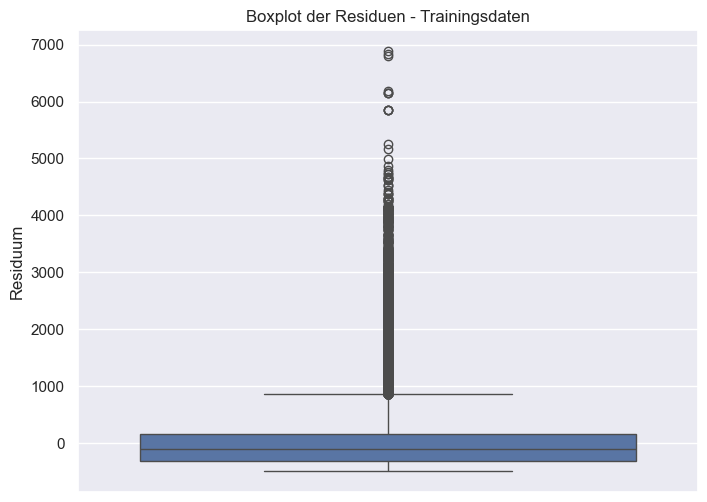

In [17]:
# Residuen aus den Trainingsdaten extrahieren
resid_train = df_pred_lmf_region_co2_TR['Residuum']

# Boxplot für Residuen der Trainingsdaten erstellen
plt.figure(figsize=(8, 6))
sns.boxplot(data=resid_train)
plt.ylabel("Residuum")
plt.title("Boxplot der Residuen - Trainingsdaten")
plt.show()

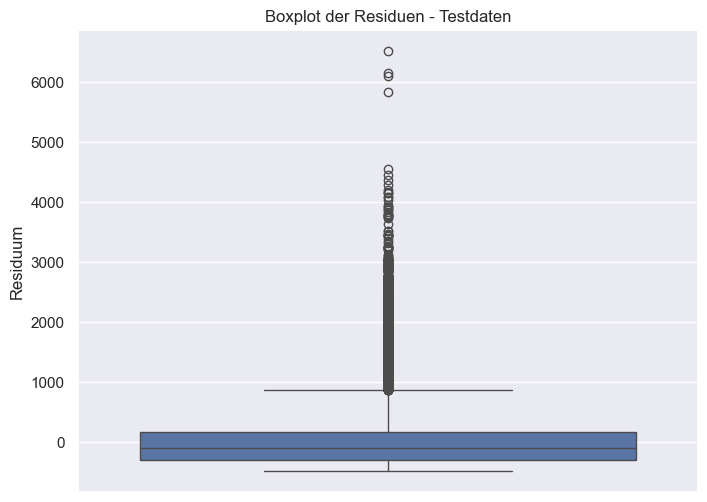

In [18]:
# Residuen aus den Testdaten extrahieren
resid_test = df_pred_lmf_region_co2_TE['Residuum']

# Boxplot für Residuen der Testdaten erstellen
plt.figure(figsize=(8, 6))
sns.boxplot(data=resid_test)
plt.ylabel("Residuum")
plt.title("Boxplot der Residuen - Testdaten")
plt.show()

Die Box repräsentiert den Interquartilsbereich (IQR), der von den 25. bis 75. Perzentilen reicht. Das bedeutet, dass 50 % der Residuen innerhalb dieser Box liegen.
Der Median der Residuen ist nahe bei 0, was darauf hinweist, dass das Modell tendenziell gut zentriert ist.
Es gibt viele Ausreisser (Punkte oberhalb der Box), die auf grosse Fehler im Modell hinweisen. Diese grossen Residuen sind wahrscheinlich extreme Abweichungen zwischen den vorhergesagten und tatsächlichen Werten.
Die Whiskers (die Linien, die aus der Box herausragen) zeigen die Verteilung der Residuen an, die nicht als Ausreisser gelten. Diese reichen bis zu den 1,5-fachen des IQRs von den Quartilen.

## 3.5. Erweiterung (komplexeres Modell)

In [19]:
## 3.6. Hinzunahme kategorischer Variablen (nebst Raumstruktur und CO2 Emissionen + Alter, Erwerbsstatus, Haushaltseinkommen, Geschlecht, Raum)
lmf_region_sozio_co2 = smf.ols('CO2E_TOTAL ~ HH_STADT_LAND + ZP_ALTER + ZP_GESL + HH_HAUSHALTSEINKOMMEN', 
                              data=train)

In [20]:
fitted_lmf_region_sozio_co2 = lmf_region_sozio_co2.fit()
fitted_lmf_region_sozio_co2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             CO2E_TOTAL   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     612.5
Date:                Sun, 08 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:02:19   Log-Likelihood:            -2.1352e+06
No. Observations:              285955   AIC:                         4.270e+06
Df Residuals:                  285950   BIC:                         4.271e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               381.3039      4.772     79.903      0.000     371.951     390.657
HH_STADT_LAND            46.8363      1.046     44.792      0.000      44.787      48.886
ZP_ALTER                  0.3878      0.051      7.591      0.000       0.288       0.488
ZP_GESL                 -29.7893      1.606    -18.544      0.000     -32.938     -26.641
HH_HAUSHALTSEINKOMMEN    -0.0002      0.000     -0.921      0.357      -0.001       0.000
==============================================================================
Omnibus:                   157647.720   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1882703.146
Skew:                           2.422   Prob(JB):                         0.00
Kurtosis:                      14.599   Cond. No.                     7.01e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Das Modell erklärt nur einen kleinen Teil der Variation in den CO2-Emissionen (R² = 0.01), was bedeutet, dass es viele andere Faktoren gibt, die das Modell nicht erfasst.
Die unabhängigen Variablen sind signifikant, aber die geringe erklärende Kraft des Modells deutet darauf hin, dass das Modell in seiner derzeitigen Form nicht ausreicht, um die CO2-Emissionen gut vorherzusagen.
Eine genauere Untersuchung der Residuen (insbesondere deren Nicht-Normalverteilung) und möglicherweise die Einbeziehung weiterer relevanter Variablen könnte erforderlich sein, um das Modell zu verbessern.

In [21]:
## 3.3. Prädiktion auf Trainings- und Testdaten
fitted_lmf_region_sozio_co2.predict(train[["HH_STADT_LAND", "ZP_ALTER", "ZP_GESL", "HH_HAUSHALTSEINKOMMEN"]] )

154659           NaN
233487           NaN
191763    389.617679
156415    416.417705
396853    449.017627
             ...    
110268    420.996112
259178    411.375919
365838           NaN
131932    379.571881
121958    373.442155
Length: 442097, dtype: float64

In [22]:
# Trainingsdaten
df_pred_lmf_region_sozio_co2_TR = get_prediction_and_residuum(fitted_lmf_region_sozio_co2, train, 
                                                  train['CO2E_TOTAL'])

# Testdaten
df_pred_lmf_region_sozio_co2_TE = get_prediction_and_residuum(fitted_lmf_region_sozio_co2, test, 
                                                  test['CO2E_TOTAL'])

In [23]:
df_pred_lmf_region_sozio_co2_TE

,Prediction,Residuum
15101,NaN,NaN
5919,NaN,NaN
507352,480.925522,1353.251508
402170,393.846031,164.175006
285488,454.059413,-426.692169
...,...,...
188461,419.520342,-407.722563
189111,519.284889,147.109190
467493,461.816007,-453.560268
551839,421.441942,-300.486354


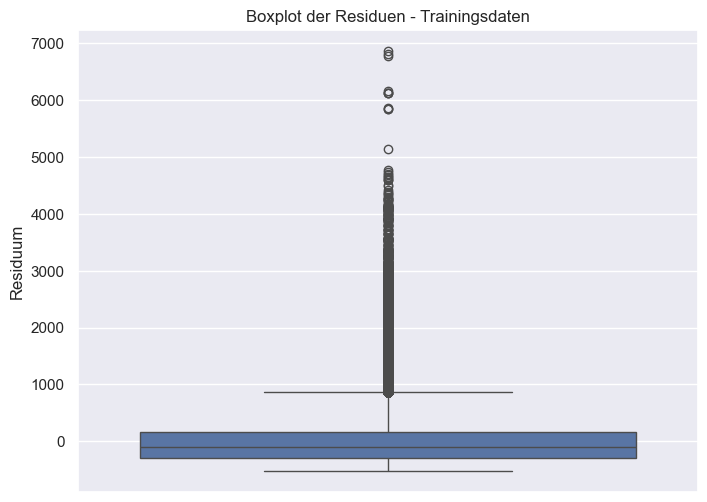

In [24]:
# Residuen aus den Trainingsdaten extrahieren
resid_train2 = df_pred_lmf_region_sozio_co2_TR['Residuum']

# Boxplot für Residuen der Trainingsdaten erstellen
plt.figure(figsize=(8, 6))
sns.boxplot(data=resid_train2)
plt.ylabel("Residuum")
plt.title("Boxplot der Residuen - Trainingsdaten")
plt.show()

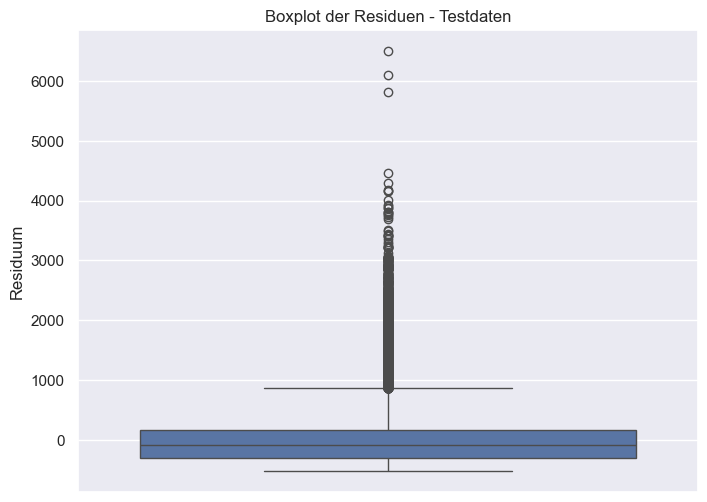

In [25]:
# Residuen aus den Testdaten extrahieren
resid_test2 = df_pred_lmf_region_sozio_co2_TE['Residuum']

# Boxplot für Residuen der Testdaten erstellen
plt.figure(figsize=(8, 6))
sns.boxplot(data=resid_test2)
plt.ylabel("Residuum")
plt.title("Boxplot der Residuen - Testdaten")
plt.show()

## Auswertung des komplexeren Modells


## 4. Feature Selection

In [28]:
## 4.1. Aufteilung der Daten
## 4.2. Modelle definieren und trainieren
## 4.3.: Modelle Auswerten auf den Validation-Daten:
## 4.4.: Vergleich der Performance auf Testdaten
## 4.5. Finale Auswertung des ausgewählten Modells auf den Testdaten